In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_3_crimes_100m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_weekly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)
mask = df['disposition'].str.contains("R 41(a)(1) Voluntary Dismissal on", na=False, regex=False)
df = df.loc[~mask, :]

In [2]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_week'
df = df.dropna(subset=treatment_date_variable)
df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_3_crimes_100m        1.083307e-04   
                                                 pre_treatment_change_in_group_3_crimes_100m       2.406979e-01   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                2.668583e-19   
                                                 job_density_2013                                  1.756579e-02   
                                                 med_hhinc2016                                     1.222842e-08   
                                                 poor_share2010                                    2.939853e-01   
                                                 popdensity2010                                    8.351007e-12   
Panel C: Case Initiation                         for_cause                                         1.879988e-01   
                                                 no_cause                                          4.195784e-01   
                                                 non_payment                                       8.323767e-02   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          7.531770e-01   
                                                 hasAttyP                                          3.103598e-01   
                                                 isEntityD                                         2.148943e-70   
                                                 isEntityP                                         5.216432e-02   

                                                                                                            
                                                                                                            
                                                 \emph{Independent Variable}                                
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_3_crimes_100m   3.857510e-02  
                                                 pre_treatment_change_in_group_3_crimes_100m  3.324820e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           8.769456e-02  
                                                 job_density_2013                             1.493548e-02  
                                                 med_hhinc2016                                1.320482e-01  
                                                 poor_share2010                               1.857107e-02  
                                                 popdensity2010                               3.176658e-02  
Panel C: Case Initiation                         for_cause                                    4.977467e-01  
                                                 no_cause                                     6.029598e-05  
                                                 non_payment                                  3.068283e-03  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     2.675542e-28  
                                                 hasAttyP                                     1.900900e-05  
                                                 isEntityD                                    1.421217e-06  
                                                 isEntityP                                    1.730992e-07

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                                   Cases Won by Plaintiff   
Panel A total_twenty_seventeen_group_3_crimes_100m               7.200253   
Panel B frac_coll_plus2010                                       0.330934   
        job_density_2013                                     17324.753036   
        med_hhinc2016                                        48534.175539   
        popdensity2010                                       23285.588974   
Panel D isEntityD                                                0.017110   

                                                   Difference in Cases Won by Defendant  \
                                                                             Unweighted   
Panel A total_twenty_seventeen_group_3_crimes_100m                             0.821423   
Panel B frac_coll_plus2010                                                     0.022607   
        job_density_2013                                                    6144.920135   
        med_hhinc2016                                                       2249.484731   
        popdensity2010                                                      1707.930970   
Panel D isEntityD                                                             -0.044171   

                                                                           \
                                                    \emph{p}     Weighted   
Panel A total_twenty_seventeen_group_3_crimes_100m  0.038575    -0.026642   
Panel B frac_coll_plus2010                          0.087695    -0.007841   
        job_density_2013                            0.014935  1756.796016   
        med_hhinc2016                               0.132048 -1615.621474   
        popdensity2010                              0.031767  -500.513777   
Panel D isEntityD                                   0.000001    -0.020211   

                                                              
                                                    \emph{p}  
Panel A total_twenty_seventeen_group_3_crimes_100m  0.942265  
Panel B frac_coll_plus2010                          0.516548  
        job_density_2013                            0.465932  
        med_hhinc2016                               0.222416  
        popdensity2010                              0.467569  
Panel D isEntityD                                   0.012281

In [5]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [6]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=34]  100%|████████████████████| 17776/17776 [00:40<00:00, 441.56it/s] 


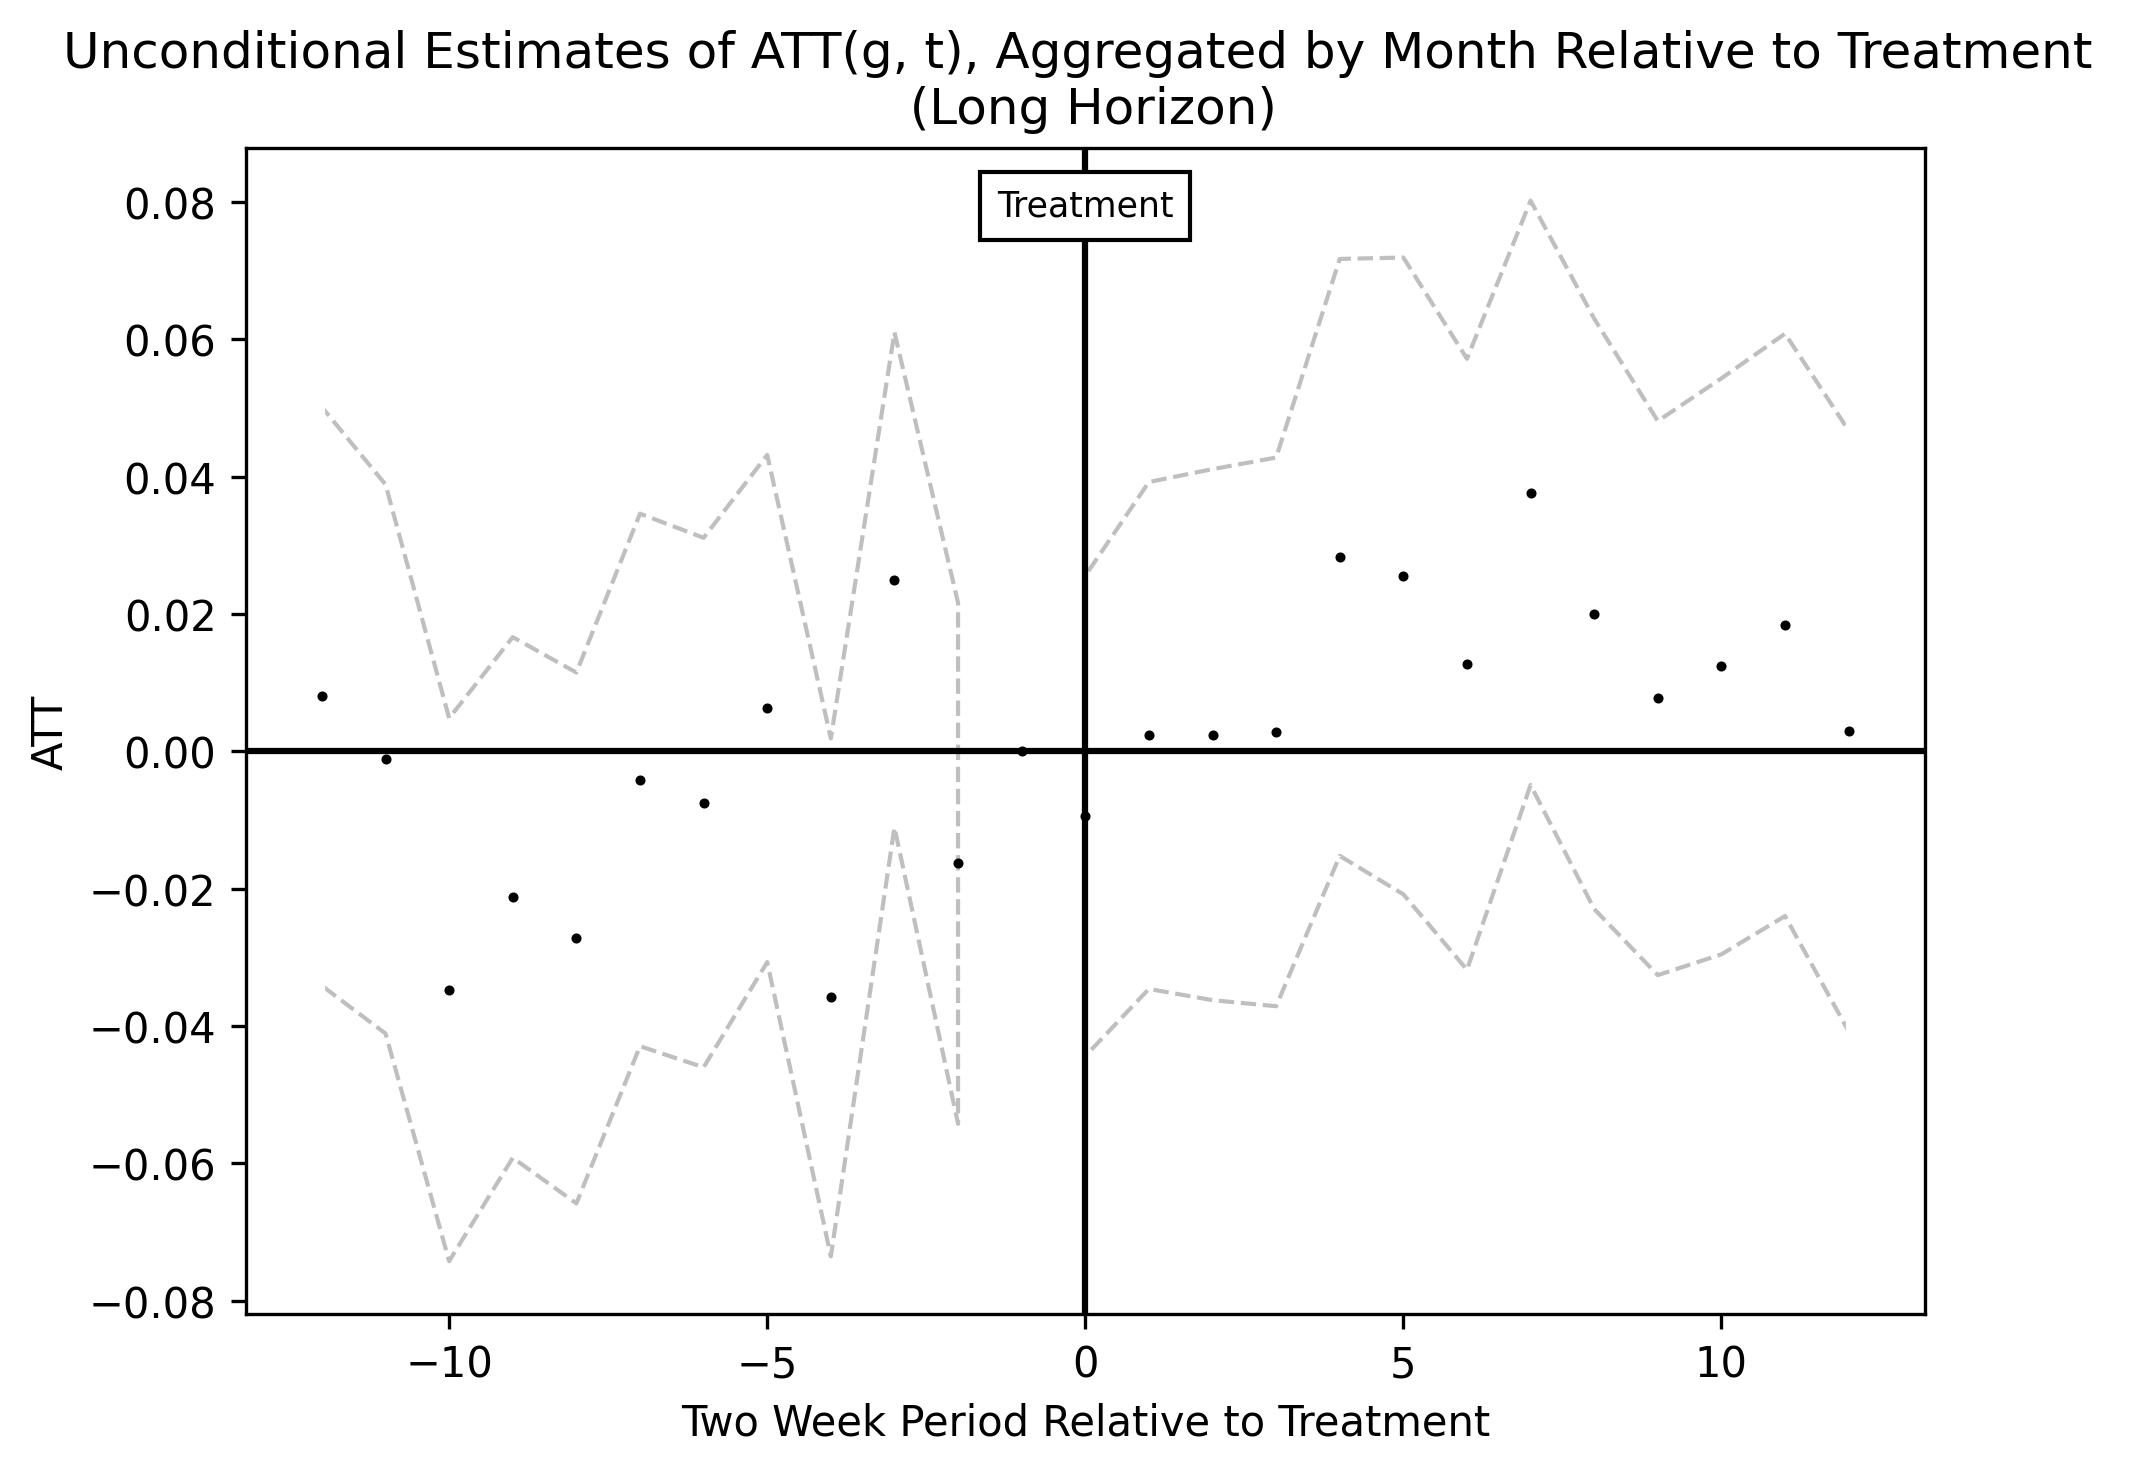

In [7]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=12,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_date_variable, df=df)

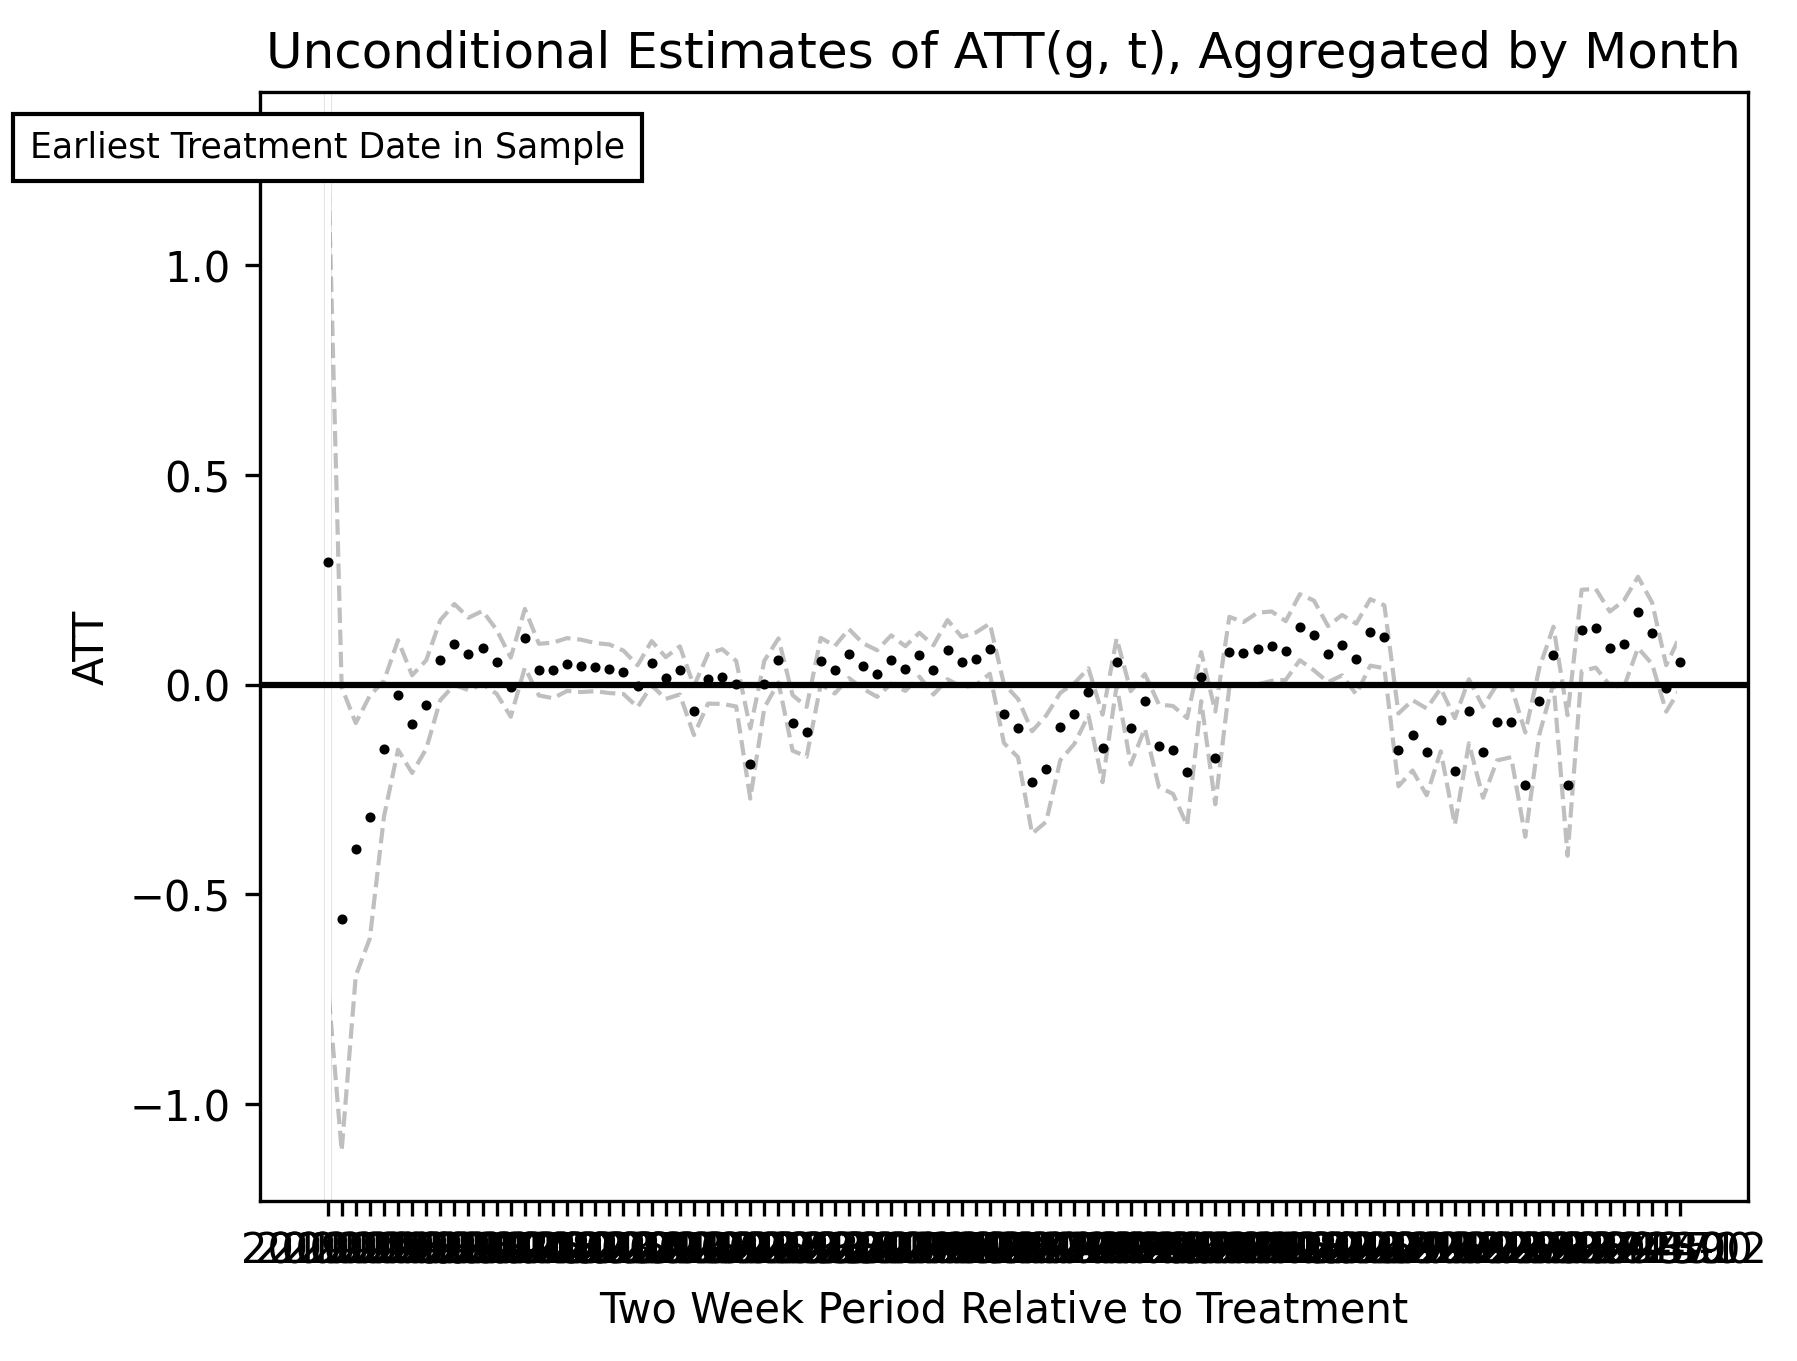

In [8]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

In [9]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=34]   32%|██████▎             | 5653/17776 [02:01<05:06, 39.49it/s]/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
Computing ATTgt [workers=34]   32%|██████▎             | 5658/17776 [02:01<05:19, 37.97it/s]/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/gpfs/home/ashanmu1/seniorthesis/venv/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow en

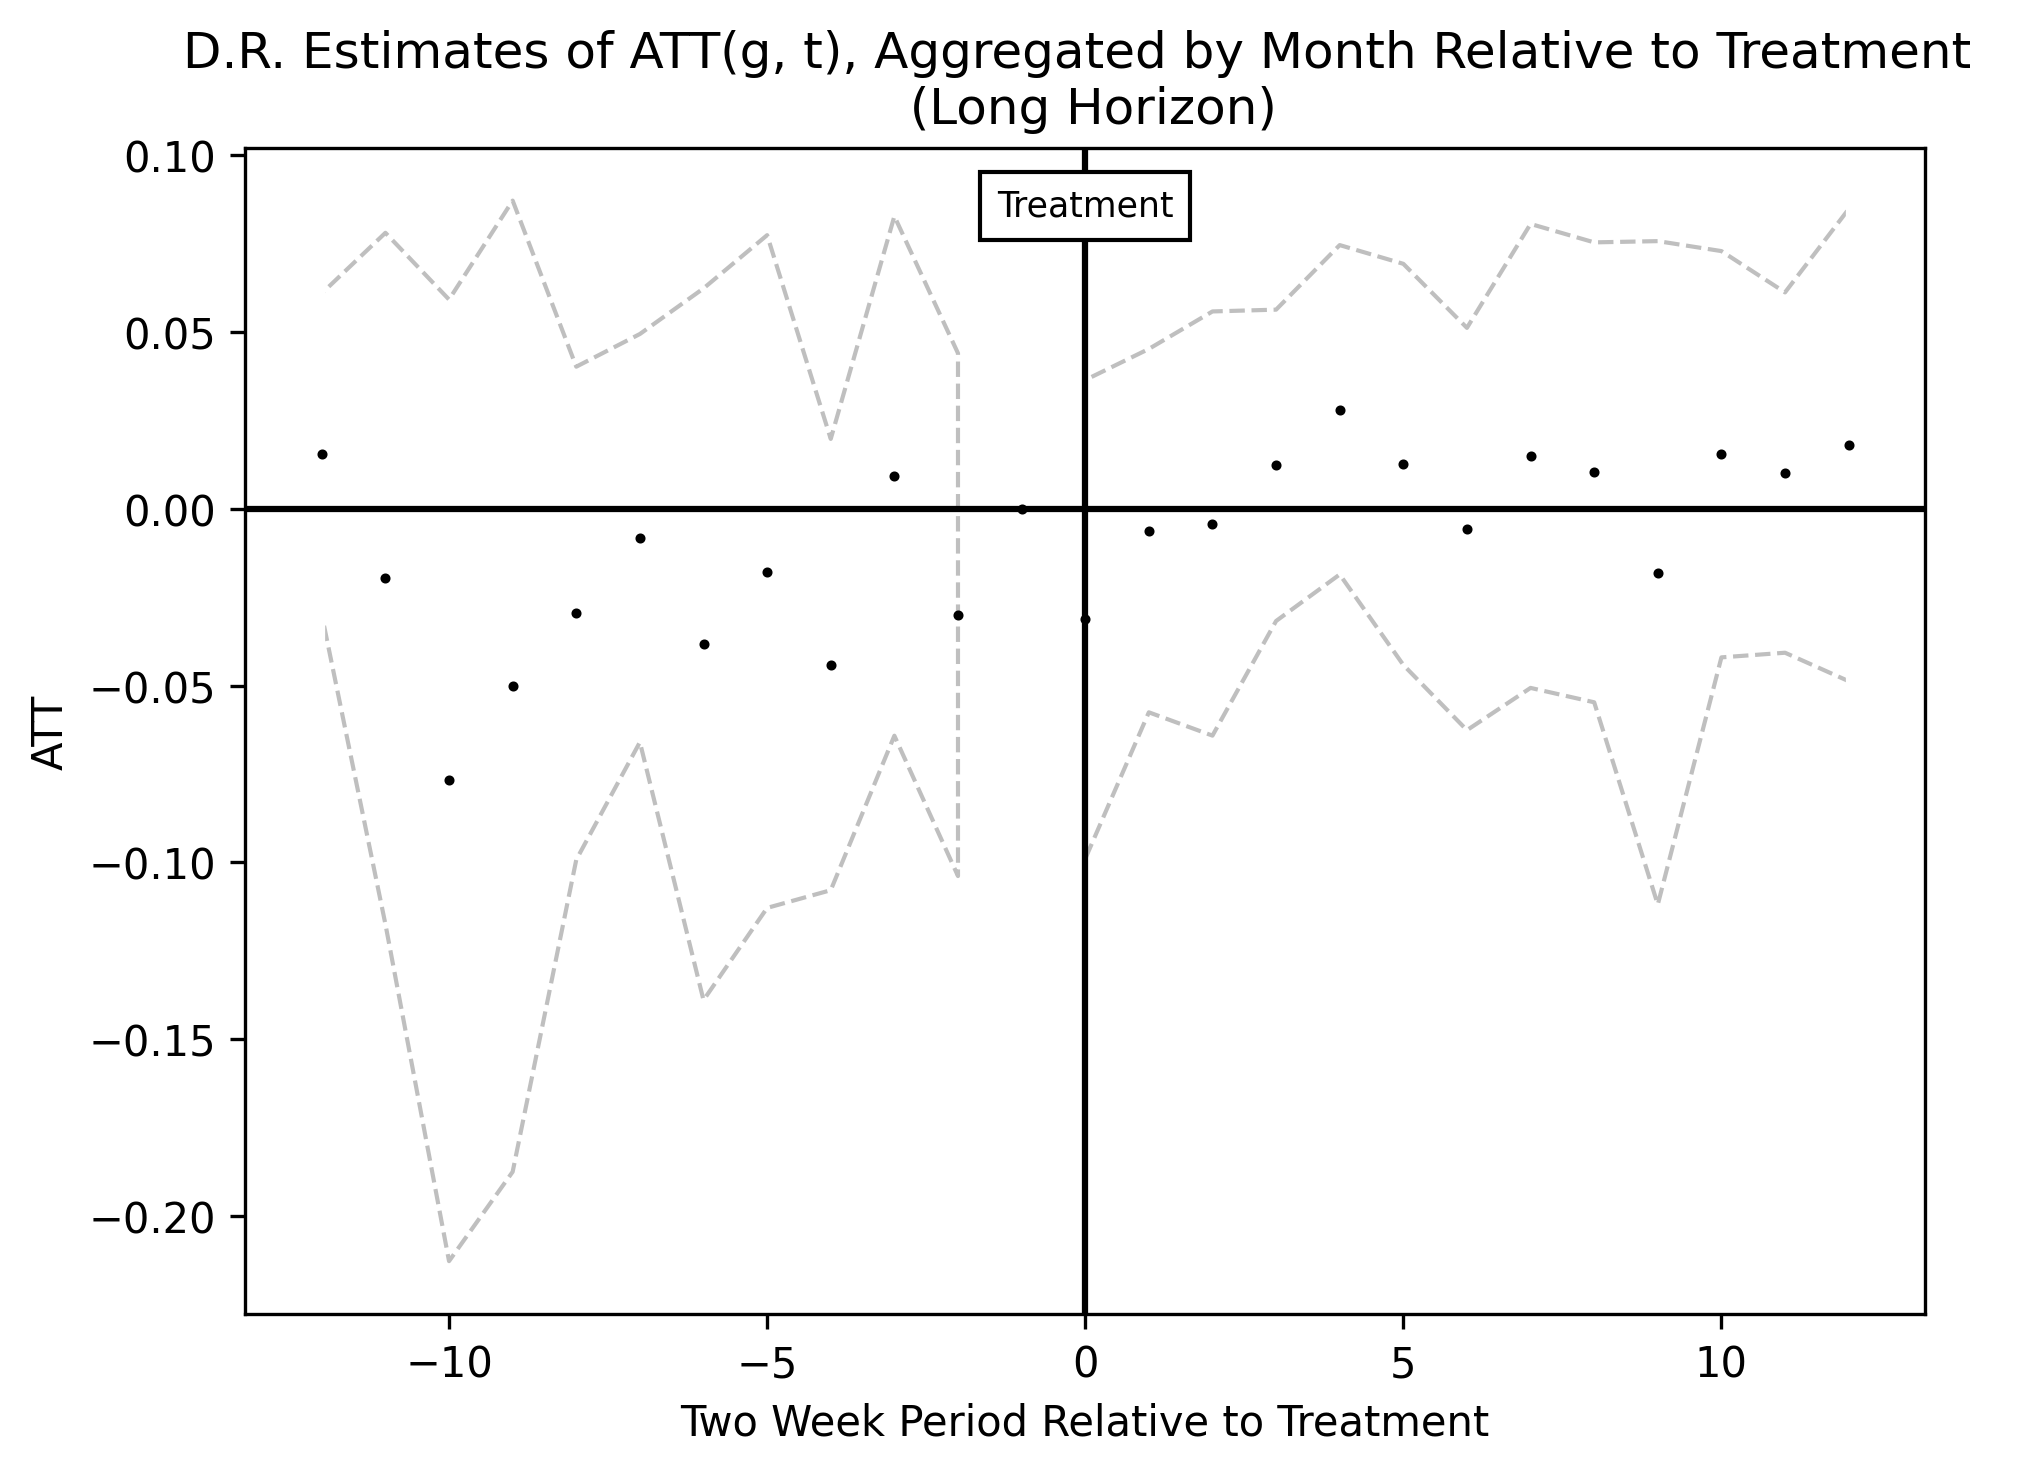

In [10]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=12,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_date_variable, df=df)

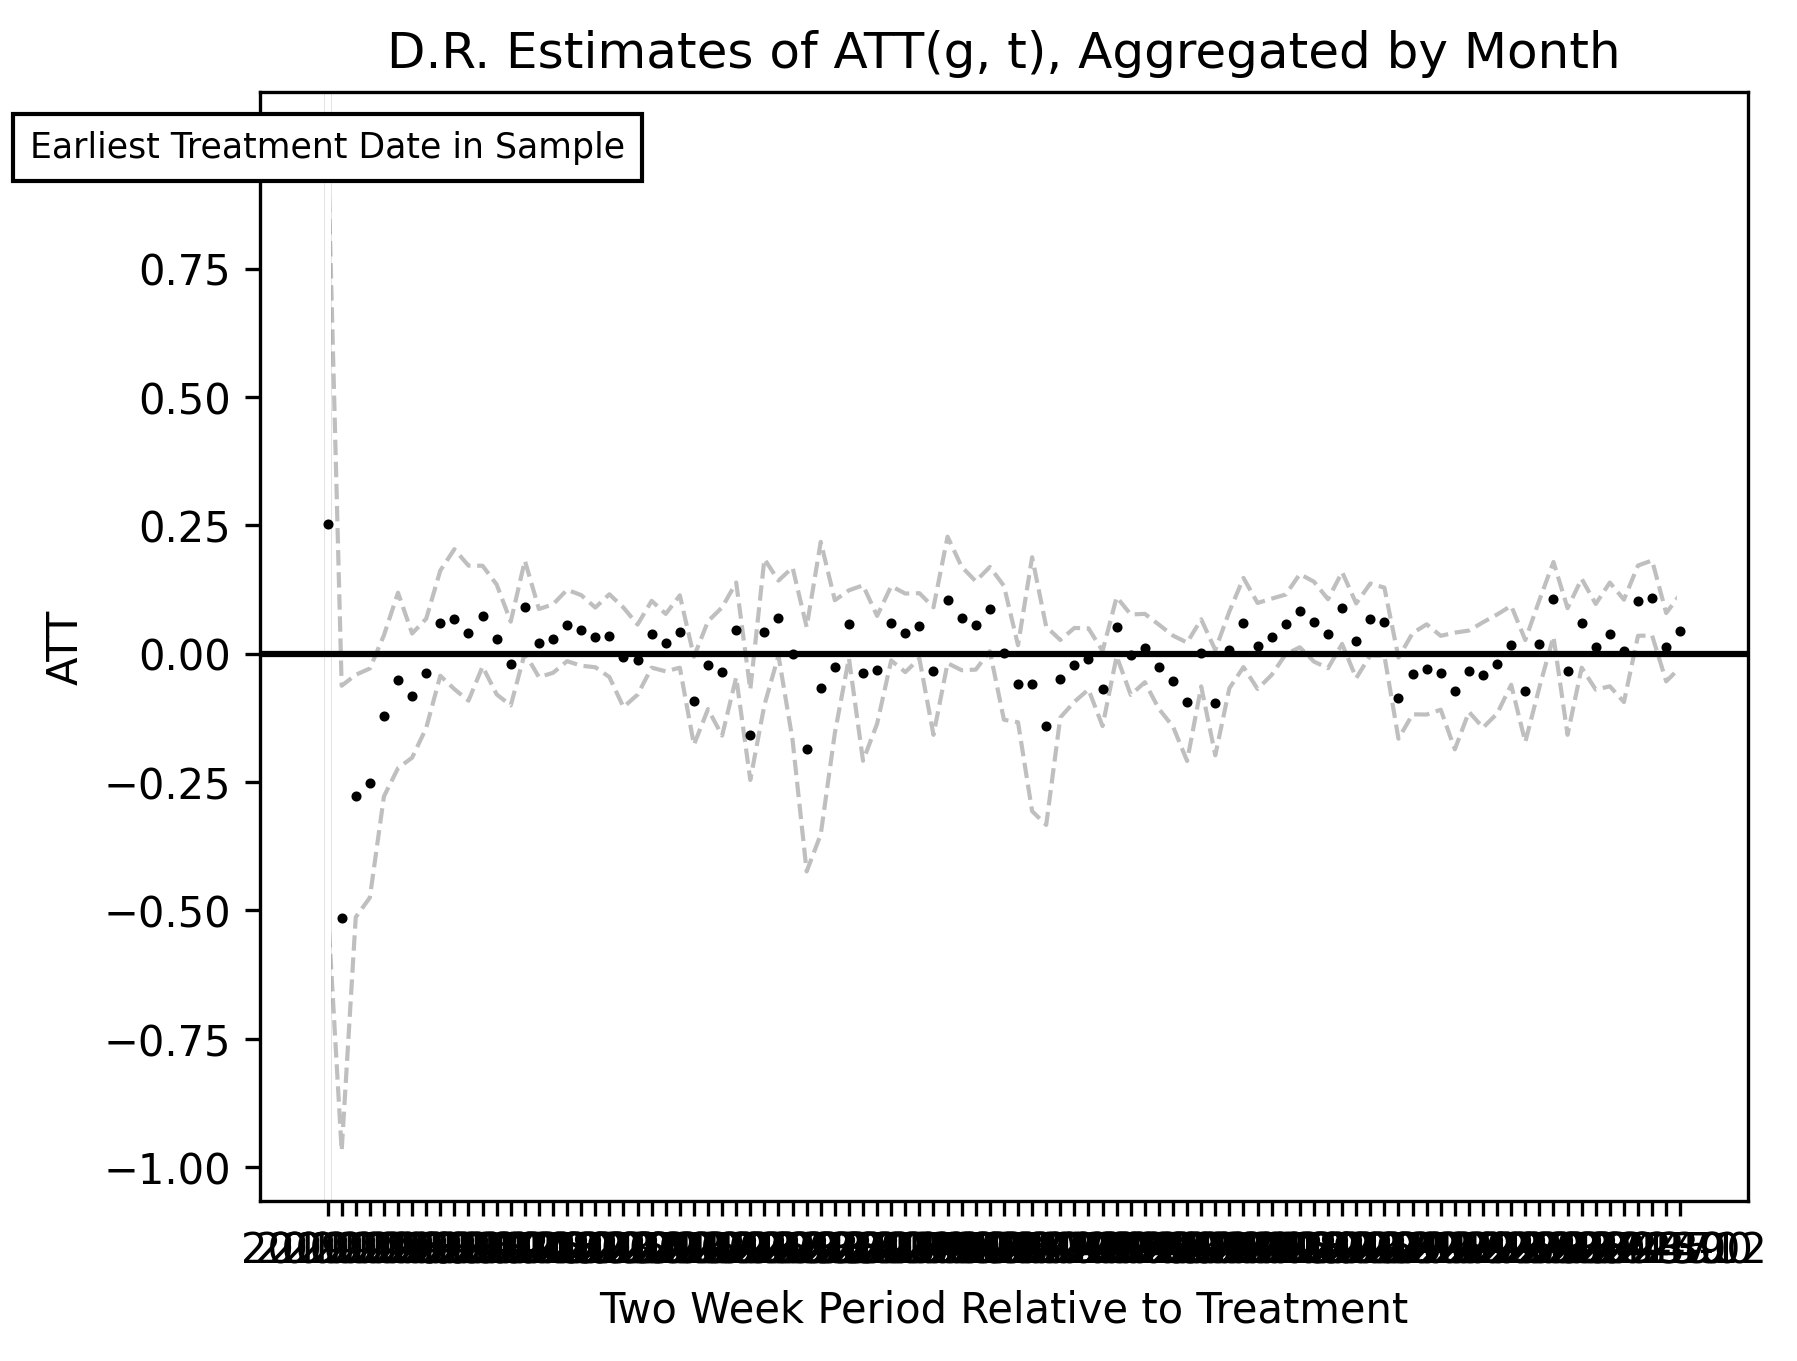

In [11]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")